In [83]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [84]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [85]:
class FeedforwardNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FeedforwardNN, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size) #bias = False?
        self.relu1 = nn.ReLU()
        self.output_layer = nn.Linear(hidden_size, output_size)
        self.multiplier = np.sqrt(hidden_size)

    def forward(self, x):
        x = self.relu1(self.layer1(x))
        x = self.output_layer(x)
        x = x*self.multiplier
        return x

# Set random seed for reproducibility
torch.manual_seed(42)

# Define synthetic input data
input_size = 20
synthetic_input = torch.rand(input_size)

# Instantiate the neural network
hidden_size = 20
output_size = 1
model_1 = FeedforwardNN(input_size, hidden_size, output_size)

# Forward pass
output = model_1(synthetic_input)

# To GPU
model_1 = model_1.to(device)

# Print the architecture and output shape
print(model)
print("Output shape:", output.shape)

FeedforwardNN(
  (layer1): Linear(in_features=20, out_features=20, bias=True)
  (relu1): ReLU()
  (output_layer): Linear(in_features=20, out_features=1, bias=True)
)
Output shape: torch.Size([1])


In [86]:
initial_weights = model_1.state_dict()

In [87]:
p = 0
for name, param in model.named_parameters():
    if 'weight' in name:
        x,y = param.size()
        p += x*y
        print(f'Layer: {name}, Size: {param.size()}')
print('Number of parameters:',p)

Layer: layer1.weight, Size: torch.Size([20, 20])
Layer: output_layer.weight, Size: torch.Size([1, 20])
Number of parameters: 420


In [88]:
def random_ball(num_points,dimension,radius = 1):
    output = []
    for n in range(num_points):
        x = np.random.randn(20)
        x /= np.linalg.norm(x, ord=2)
        x = torch.tensor(x,dtype = torch.float32)
        if num_points == 1:
            return x
        output.append(x)
    return torch.stack(output)

In [89]:
# Careful: Adding too much noise breaks it as the noise takes over. But noise doesn't break if the reward is high

a = random_ball(1,20,1).reshape(-1).to(device)
def reward_function_quadratic(context):
#     return 10*(torch.dot(context,a)**2).item() + (0.1*torch.randn(1)).item()
    return 10*(torch.dot(context,a)**2).item()
reward_function_quadratic(random_ball(1,20).to(device))

0.011334898881614208

In [90]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, predicted, target,flattened_initial_weights,flattened_current_weights):
        loss = (0.5*torch.sum((predicted - target)**2))/target.shape[0]
        m = 20
        lamb = 1
        norm = 0.5*m*lamb*(torch.norm(flattened_initial_weights - flattened_current_weights, p=2)**2)
        return loss + norm

In [91]:
def train_nn(input_data,best_rewards,initial_weights,step_size, J = 20):
    model_inside = FeedforwardNN(input_size, hidden_size, output_size).to(device)
    model_inside.load_state_dict(initial_weights)

    loss_function = CustomLoss()

    optimizer = optim.SGD(model_inside.parameters(),lr = step_size) # Need to fix to GD?
    size = len(input_data)
    rewards = torch.tensor(best_rewards).reshape(-1,1)
    dataset = TensorDataset(input_data,rewards)
    
    batch_size = 50
    shuffle = True  # Set to True if you want to shuffle the data
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)    

    flattened_initial_weights = torch.cat([p.flatten() for p in initial_weights.values()])
    
    for j in range(J):
        for inputs,targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            output = model_inside(inputs)
            current_weights = model_inside.state_dict()
            flattened_current_weights = torch.cat([p.flatten() for p in current_weights.values()])
            loss = loss_function(output, targets,flattened_initial_weights,flattened_current_weights)
            loss.backward()
            optimizer.step()
        
    print('--------------------------------------')

    model_weights = model_inside.state_dict()
    return model_weights

In [92]:
def get_regret(data,best_action,reward_function):
    best_reward = -np.inf
    rewards = []
    for idx,t in enumerate(data):
        reward = reward_function(t)
        if reward > best_reward:
            best_reward = reward
            best_idx = idx
            
        rewards.append(reward)
            
    chosen_reward = rewards[best_action]
    regret = best_reward - chosen_reward
    return regret

In [94]:
def NeuralUCB(model,reward_function, T, lamb = 1, step_size = 0.001):
    Z = lamb * torch.eye(p).to(device)
    K = 4
    dim = 20 # feature vector dimension (context)
    m = 20 # Neural Network width
    gamma = 1
    best_contexts = []
    best_rewards = []
    regrets = []
    for t in range(T):
        synthetic_input = random_ball(K,dim).to(device) # "K" arms x "dim" feature size
        all_grad = []
        ucbs = []
        for k in range(K):
            output = model(synthetic_input[k])
            model.zero_grad()
            output.backward(torch.ones_like(output),retain_graph = True)
            g = []
            for name, param in model.named_parameters():
                if 'weight' in name:
                    tmp = param.grad.flatten()
                    g.append(tmp)
            g = torch.cat(g,dim = 0).reshape(-1,1).to(device)
    
    
            Z_inv = torch.inverse(Z)
            
            
            all_grad.append(g)
            exploration_reward = gamma*torch.sqrt((g.T@Z_inv@g)/m) 
            ucb_a = output + exploration_reward
            ucbs.append(ucb_a.item())
            
            
        ucbs = torch.tensor(ucbs)
        best_action = torch.argmax(ucbs).item()
        best_context = synthetic_input[best_action]
        best_g = all_grad[best_action]
        best_reward = reward_function(best_context)
        Z = Z + (best_g@best_g.T/m)
        
        best_contexts.append(best_context)
        
        
        best_rewards.append(best_reward)
        
        
        
        if (t+1)%50 == 0:
            ### Train Neural Network
            new_weights = train_nn(torch.stack(best_contexts),
                                   torch.tensor(best_rewards),
                                   initial_weights,
                                   step_size = step_size,
                                   J = t+1)
            model.load_state_dict(new_weights)
            print(f'Training NN step {t+1}')
            print('Cumulative Regret: ' , np.sum(regrets))

        regret = get_regret(synthetic_input,best_action,reward_function)
        regrets.append(regret)
        
        # Update gamma: To be updated        
        
        
        
    return model,regrets

### Quadratic function

In [95]:
model_1,regrets_1 = NeuralUCB(model_1,reward_function_quadratic,1000)

C:\Users\chana\AppData\Local\Temp\ipykernel_5232\4264651518.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards = torch.tensor(best_rewards).reshape(-1,1)


--------------------------------------
Training NN step 50
Cumulative Regret:  45.168156837147535
--------------------------------------
Training NN step 100
Cumulative Regret:  74.55444007758217
--------------------------------------
Training NN step 150
Cumulative Regret:  109.0338774816563
--------------------------------------
Training NN step 200
Cumulative Regret:  149.7896138492415
--------------------------------------
Training NN step 250
Cumulative Regret:  191.7851577132733
--------------------------------------
Training NN step 300
Cumulative Regret:  218.0211024278451
--------------------------------------
Training NN step 350
Cumulative Regret:  255.0691319026912
--------------------------------------
Training NN step 400
Cumulative Regret:  284.24198550041115
--------------------------------------
Training NN step 450
Cumulative Regret:  307.60616786239484
--------------------------------------
Training NN step 500
Cumulative Regret:  325.5415655374229
------------------

In [96]:
def plot_cumulative(data):
    cumulative_sum = np.cumsum(data)
    plt.plot(cumulative_sum)
    plt.xlabel('Index')
    plt.ylabel('Cumulative Sum')
    plt.title('Cumulative Sum Plot')
    plt.grid(True)
    plt.show()

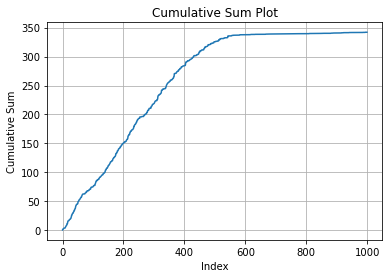

In [97]:
plot_cumulative(regrets_1)

## cos function

In [98]:
model_2 = FeedforwardNN(input_size, hidden_size, output_size)
model_2 = model_2.to(device)
initial_weights = model_2.state_dict()

In [99]:
a = random_ball(1,20,1).reshape(-1).to(device)
def reward_function_cos(context):
#     return np.cos(3*(torch.dot(context,a)).item()) + (0.1*torch.randn(1)).item()
    return np.cos(3*(torch.dot(context,a)).item())
reward_function_cos(random_ball(1,20).to(device))

0.9758040299147253

In [100]:
model_2,regrets_2 = NeuralUCB(model_2,reward_function_cos,1000)

C:\Users\chana\AppData\Local\Temp\ipykernel_5232\4264651518.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards = torch.tensor(best_rewards).reshape(-1,1)


--------------------------------------
Training NN step 50
Cumulative Regret:  11.662173787851904
--------------------------------------
Training NN step 100
Cumulative Regret:  19.38400291256239
--------------------------------------
Training NN step 150
Cumulative Regret:  28.94013721369631
--------------------------------------
Training NN step 200
Cumulative Regret:  39.63062203155017
--------------------------------------
Training NN step 250
Cumulative Regret:  48.5333212273257
--------------------------------------
Training NN step 300
Cumulative Regret:  57.52727181906832
--------------------------------------
Training NN step 350
Cumulative Regret:  64.14103315228184
--------------------------------------
Training NN step 400
Cumulative Regret:  71.52750596614095
--------------------------------------
Training NN step 450
Cumulative Regret:  77.48958204645669
--------------------------------------
Training NN step 500
Cumulative Regret:  81.77514215470117
---------------------

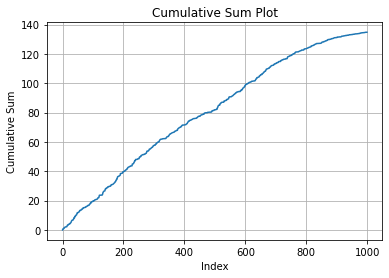

In [101]:
plot_cumulative(regrets_2)

### Result Testing: Quadratic

In [120]:
test = random_ball(4,20).to(device)
print(test)

tensor([[-0.1073,  0.1777,  0.0918,  0.3539, -0.5695,  0.4650, -0.1477,  0.0625,
          0.1288,  0.0721, -0.0913,  0.0154, -0.2701, -0.1398, -0.0930, -0.0077,
          0.1921, -0.0907,  0.1911, -0.2092],
        [-0.1115,  0.2102,  0.0686, -0.1705, -0.0616, -0.1127,  0.0391, -0.2115,
         -0.1377,  0.2499,  0.2669, -0.0507, -0.2402, -0.0702, -0.2073,  0.1955,
         -0.6406, -0.2854, -0.0167, -0.2361],
        [ 0.0685,  0.0412, -0.4259, -0.1196, -0.0882, -0.0962, -0.0057, -0.0676,
          0.0346, -0.0910, -0.3477,  0.3334,  0.2959, -0.2849,  0.2811, -0.2330,
          0.1737,  0.2769, -0.0101,  0.3546],
        [ 0.0293,  0.2087, -0.1164,  0.1694,  0.2786, -0.2941,  0.2323,  0.1200,
          0.1202, -0.1626, -0.0307, -0.2314, -0.3516, -0.0258, -0.5653, -0.0014,
          0.3379,  0.0718, -0.1325,  0.0701]], device='cuda:0')


In [121]:
best_idx = 0
best_reward = 0
for idx,t in enumerate(test):
    reward = reward_function_quadratic(t)
    if reward>best_reward:
        best_reward = reward
        best_idx = idx
    print(f'idx_{idx} reward: ',reward)

idx_0 reward:  0.07720309775322676
idx_1 reward:  0.22185439243912697
idx_2 reward:  0.001190077091450803
idx_3 reward:  2.8516820073127747


In [122]:
model_1(test)

tensor([[-0.0041],
        [ 0.5695],
        [ 0.8901],
        [ 1.0503]], device='cuda:0', grad_fn=<MulBackward0>)

### Result Testing: Cos

In [123]:
test = random_ball(4,20).to(device)

In [124]:
best_idx = 0
best_reward = 0
for idx,t in enumerate(test):
    reward = reward_function_cos(t)
    if reward>best_reward:
        best_reward = reward
        best_idx = idx
    print(f'idx_{idx} reward: ',reward)

idx_0 reward:  0.4774932867786779
idx_1 reward:  0.8696580362992166
idx_2 reward:  0.9993214968694213
idx_3 reward:  0.5309413908425611


In [125]:
model_2(test)

tensor([[0.5444],
        [0.8273],
        [0.9741],
        [0.5354]], device='cuda:0', grad_fn=<MulBackward0>)